# Árbol de decisión

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import shap
import seaborn as sns
import time

# Utilizamos una semilla para que los resultados sean reproducibles
RANDOM_STATE = 22

## Carga de datos

In [2]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test.csv')

In [3]:
X_train = train.copy().drop(columns=['fetal_health'])
y_train = train['fetal_health']

X_val = val.copy().drop(columns=['fetal_health'])
y_val = val['fetal_health']

X_test = test.copy().drop(columns=['fetal_health'])
y_test = test['fetal_health']

## Ajuste del modelo

### Exploración de hiperparámetros

A continuación hacemos una exploración de los hiperparámetros del modelo con el objetivo de conseguir una parametrización óptima para nuestro problema. Para ello, entrenamos el árbol con los datos de `train` y evaluamos su rendimiento con los datos de `eval` para cada combinación de hiperparámetros.

In [4]:
criterion = ['gini', 'entropy']
max_depths = [i for i in range(1, 21)]
min_samples_splits = [i for i in range(2, 21)]
min_samples_leafs = [i for i in range(1, 21)]

best_f1 = 0
best_accuracy = 0
best_criteria = ''
best_depth = 0
best_split = 0
best_leaf = 0

for criteria in criterion:
    for depth in max_depths:
        for split in min_samples_splits:
            for leaf in min_samples_leafs:
                model = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                               criterion=criteria,
                                               max_depth=depth,
                                               min_samples_split=split,
                                               min_samples_leaf=leaf,
                                               class_weight='balanced')
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                f1 = f1_score(y_val, y_pred, average='weighted')
                accuracy = model.score(X_val, y_val)

                if f1 > best_f1:
                    best_f1 = f1
                    best_accuracy = accuracy
                    best_criteria = criteria
                    best_depth = depth
                    best_split = split
                    best_leaf = leaf

print('Best f1: ', best_f1)
print('Best accuracy: ', best_accuracy)
print('Best criteria: ', best_criteria)
print('Best depth: ', best_depth)
print('Best split: ', best_split)
print('Best leaf: ', best_leaf)

Best f1:  0.9258262156866529
Best accuracy:  0.9248826291079812
Best criteria:  entropy
Best depth:  11
Best split:  2
Best leaf:  1


Puede parecer que un `min_samples_split` y un `min_samples_leaf` tan bajos pueden implicar un sobreajuste del modelo, pero en este caso no es así. Los datos están estratificados, por lo que hay la misma proporción de cada clase en `train` y en `eval`. Al haber probado todas las combinaciones de hiperparámetros, y haber elegido la mejor en base a su F1 score en `eval`, podemos asegurar que la combinación óptima es la que hemos encontrado. Es decir, que ante datos nuevos, esta combinación de hiperparámetros es la que mejor generalizará.

Con la mejor combinación de hiperparámetros encontrada, entrenamos el modelo con los datos de `train + eval` y evaluamos su rendimiento con los datos de `test`, que son datos no vistos hasta el momento de predecirlos. De esta forma, podemos hacernos una idea de cómo se comportaría el modelo en producción.

In [6]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

model = DecisionTreeClassifier(random_state=RANDOM_STATE,
                               criterion=best_criteria,
                               max_depth=best_depth,
                               min_samples_split=best_split,
                               min_samples_leaf=best_leaf,
                               class_weight='balanced')

init_time = time.time()
model.fit(X_train_val, y_train_val)
fitting_time = time.time() - init_time
print('Fitting time: {:.2f} seconds'.format(fitting_time))
y_pred = model.predict(X_test)

print()
print('Train accuracy: ', model.score(X_train_val, y_train_val))
print('Train f1: ', f1_score(y_train_val, model.predict(X_train_val), average='weighted'))
print('Test accuracy: ', model.score(X_test, y_test))
print('Test f1: ', f1_score(y_test, y_pred, average='weighted'))

Fitting time: 0.02 seconds

Train accuracy:  0.9870664315108759
Train f1:  0.9872259132259239
Test accuracy:  0.92
Test f1:  0.9209956202991924


## Análisis de resultados

Para el análisis de resultados de los modelos arbóreos (árbol de decisión y XGBoost), vamos a aprovechar su explicabilidad para poder entender cómo se comporta el modelo y qué variables son las más importantes para la toma de decisiones. Por tanto, vamos a analizar la importancia de variables y los valores SHAP.

In [7]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       331
         2.0       0.73      0.78      0.75        59
         3.0       0.89      0.91      0.90        35

    accuracy                           0.92       425
   macro avg       0.86      0.88      0.87       425
weighted avg       0.92      0.92      0.92       425



Teniendo en cuenta que el recall de la clase `pathological` es 0.91 y que el F1 general es 0.92, vemos que es un modelo que funciona bastante bien. Esto implica que el 91% de los pacientes con patología son detectados correctamente, que era nuestro objetivo principal.

Para realizar un análisis más detallado de estas predicciones podemos ver la matriz de confusión.

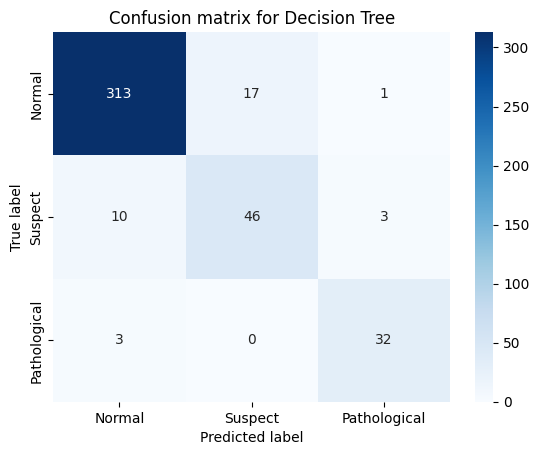

In [8]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Suspect', 'Pathological'], 
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for Decision Tree')
plt.show()

Resulta muy llamativo que de los 35 pacientes con patología, 3 no son detectados por el modelo y estos 3 son categorizados como `normal` en vez de como `suspect`. Esto es un problema, ya que estos pacientes no serían derivados a un especialista para que les realice un estudio más exhaustivo. Por tanto, el modelo no es perfecto y se podría mejorar.

En la ejecución posterior de XGBoost, trataremos de ver si estos 3 pacientes son correctamente clasificados por un modelo más robusto y complejo, o si por el contrario, el problema es inherente a los datos.

También apreciamos una alta confusión clasificando como `normal` a pacientes `suspect`. Esto puede deberse a que los pacientes `suspect` tienen valores muy similares a los de los pacientes `normal` en algunas variables, por lo que el modelo no es capaz de diferenciarlos correctamente.

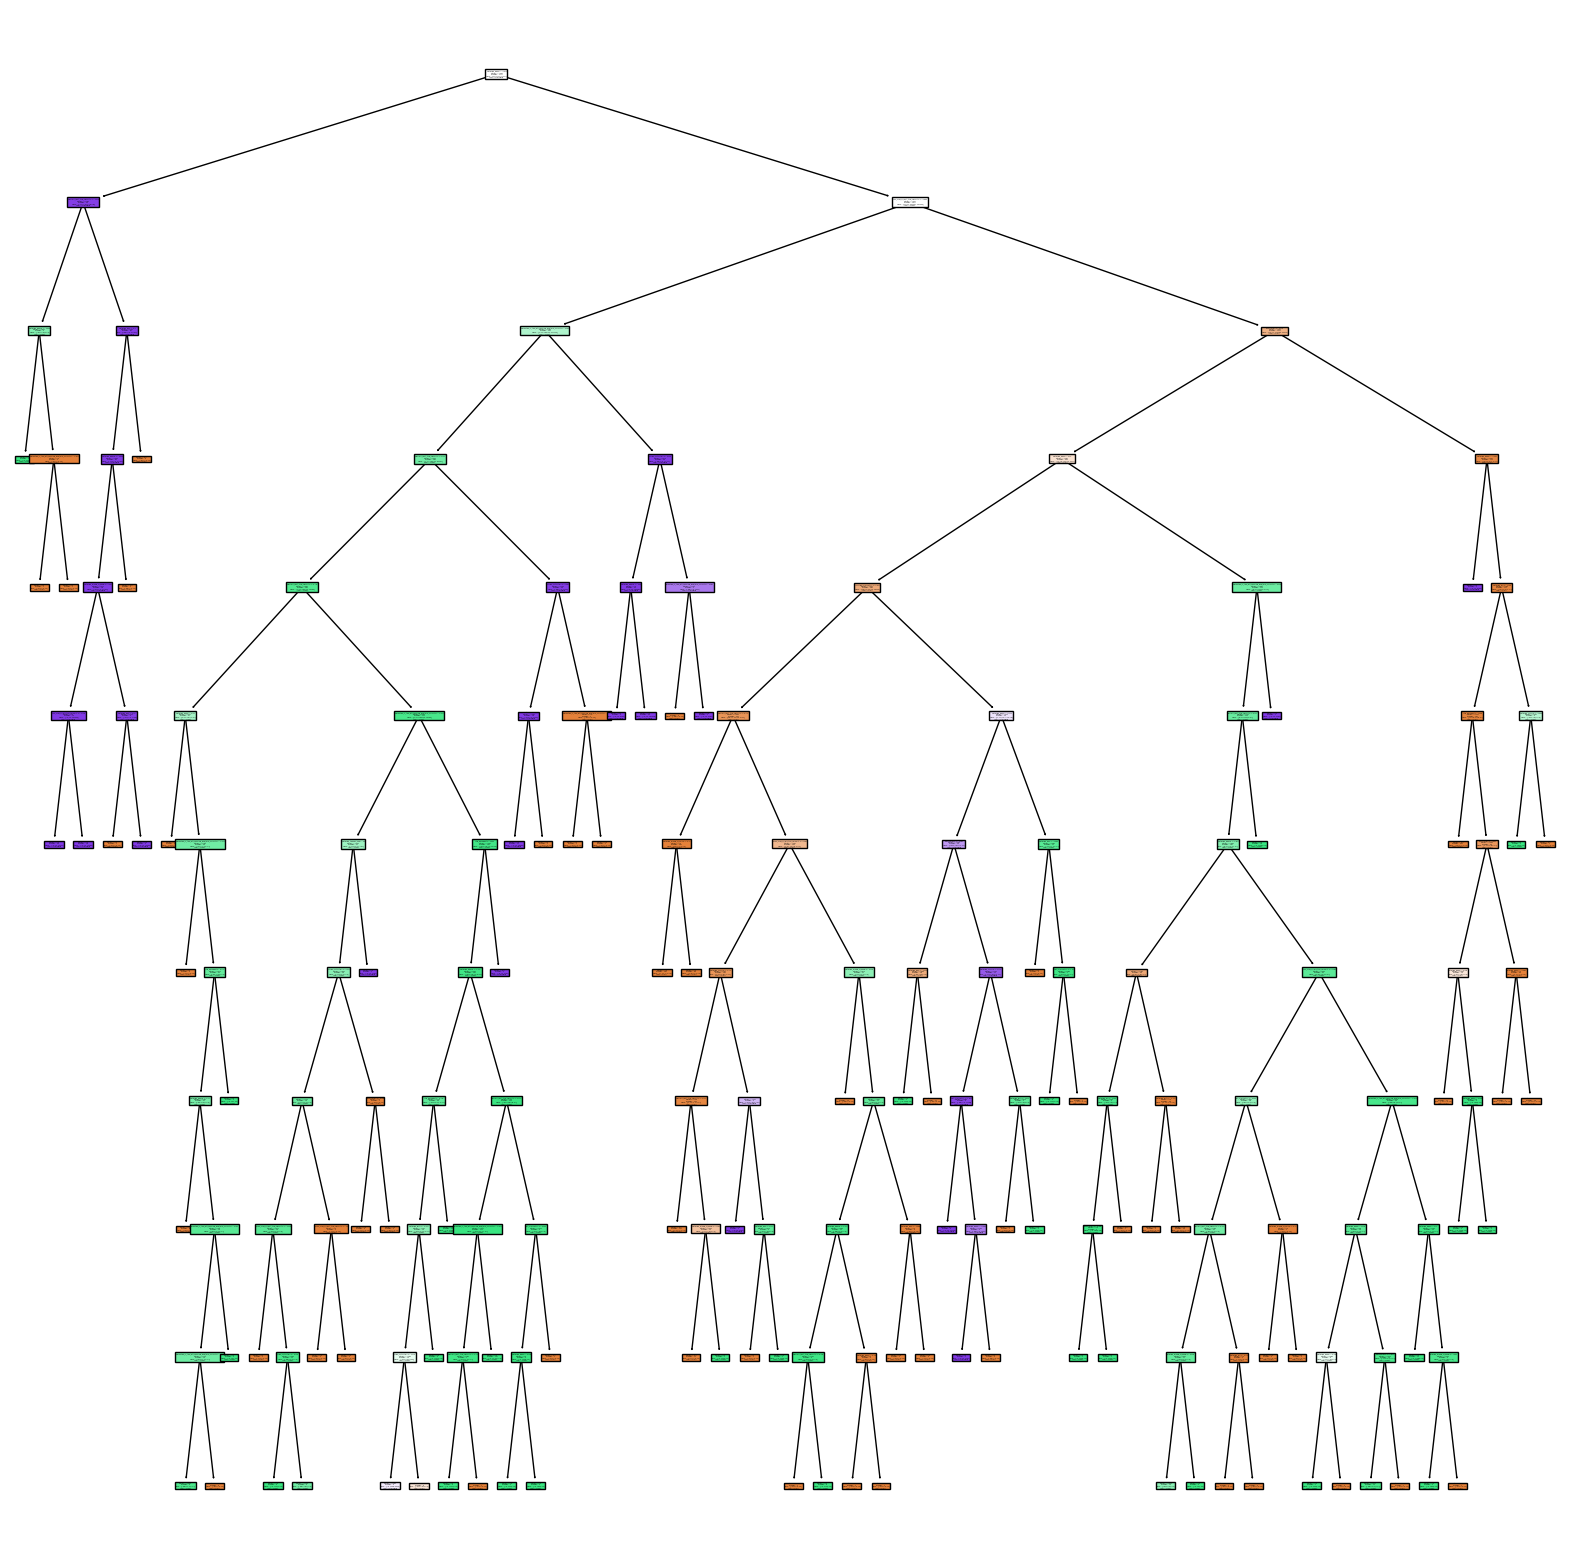

In [9]:
plt.figure(figsize=(20, 20))
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['Normal', 'Suspect', 'Pathological'])
plt.show()

Vemos que el árbol generado es muy complejo y difícil de analizar. Esto tiene sentido dado el alto número de variables que tenemos y la cantidad de combinaciones que se pueden dar. Por tanto, para hacer nuestro análisis más explicable, vamos a analizar la importancia de variables y los valores SHAP.

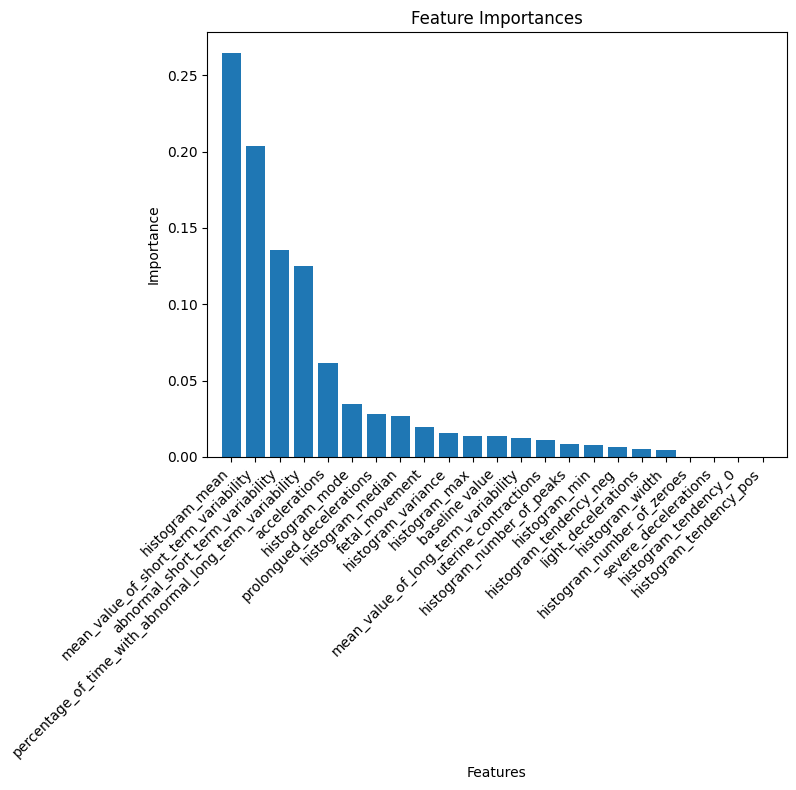

In [18]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Las variables que más importancia tienen en el árbol son `histogram_mean` y `mean_value_of_short_term_variability`, con bastante diferencia sobre las demás.

Llama la atención que `histogram_mean` sí que tiene una correlación negativa elevada con la variable objetivo (-0.23), pero `mean_value_of_short_term_variability` tiene tan solo una correlación de -0.10. Esto demuestra la necesidad de utilizar técnicas de aprendizaje automático para poder encontrar relaciones no visibles a priori entre variables.

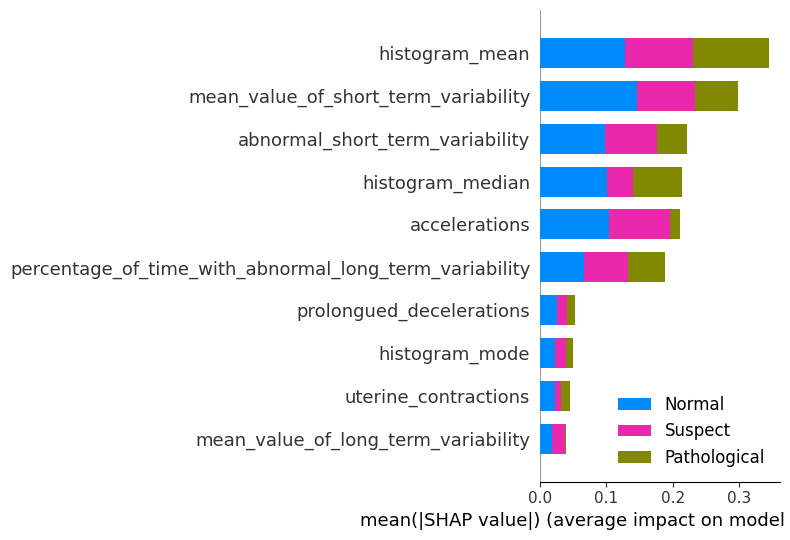

In [12]:
# shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_val)

shap.summary_plot(shap_values, X_train_val, plot_type="bar", class_names=['Normal', 'Suspect', 'Pathological'], max_display=10)

Los valores SHAP de cada variable nos muestran el impacto que tiene esa variable en la predicción del modelo por cada clase.

Vemos, por ejemplo, que aunque la variable `mean_value_of_short_term_variability` tiene un menor impacto en general que la variable `histogram_mean`, para la clase "Normal" (en color azul) es al contrario, ya que `mean_value_of_short_term_variability` es la variable con el mayor impacto.

Como hemos mencionado previamente, lo fundamental en este problema es detectar el máximo posible de casos pertenecientes a la clase "Pathological" (color verde en el gráfico). En este sentido, vemos que las variables más importantes son `histogram_mean` y `histogram_median`. Por tanto, estas son variables que nos interesaría tener en cuenta especialmente para la toma de decisiones.

## Conclusiones

En este notebook hemos entrenado un árbol de decisión para clasificar la salud de los fetos en función de si tienen patología, son sospechosos, o no presentan ningún riesgo. Hemos visto que el modelo funciona bastante bien, pero que tiene margen de mejora.

El árbol de decisión es el modelo con peor rendimiento en cuanto a F1. Sin embargo, este empeoramiento es relativamente pequeño y el modelo es mucho más interpretable y explicable que los otros modelos. Además, es el modelo que menos tiempo de entrenamiento requiere y el que menos recursos consume. Por tanto, es un modelo que podría ser interesante para utilizar en producción por sus ventajas en cuanto a coste y explicabilidad.